# Import Data

<br>
<br>

Below are brief explanations of what data we are importing and what these variables represent
* `ALL_DATA` _(data frame)_ - is our main data set 
* `poke_types` _(data frame)_ - is a seperate data set that contains a mapping of Pokemon IDs to pokemon name and types. This will be important as our main dependant variable will be **Pokemon type**
* `pokemonId_ALL` _(list/array)_ - of all unique pokemon IDs that exist in `ALL_DATA` from smallest to biggest number. 

<br>
<br>
<br>
<br>


In [13]:
import pandas as pd # data frames
import numpy as np # ____number generation
import statsmodels.formula.api as smf # for linear modeling
import matplotlib.pyplot as plt # plotting

import os.path # check if data file already exists
import json # save dictionary strucs

In [14]:
ALL_DATA = pd.read_csv('data/300k.csv')

KeyboardInterrupt: 

In [ ]:
poke_types = pd.read_csv('data/pokeId.csv')
poke_types = poke_types[['#', "Name", "Type 1", "Type 2"]]
pokemonId_ALL = set(ALL_DATA.pokemonId)

<br>
<br>
<br>

## Small Helper Functions

In [19]:
def encode_type_data(data):
    """
    Takes in Type data, Returns an array of encoded Pokemon Type data
    """
    unique_types = list(data.unique())
    results = []
    for val in data:
        results.append(unique_types.index(val))
    return results

In [ ]:
def printAllFeatures():
    cols = ALL_DATA.columns
    for col in cols:
        print(col)

<br>
<br>
<br>

## Prepare Data

In [ ]:
# Create a mapping of IDs to type, secondary type, and name. We need to do this in order to add the
# appropriate type to each pokemon in our main data set.

pokeId_toType = {}

if not os.path.exists("data/pokeId_toType.json"): 
    
    print("Looks like you don't have the Pokemon ID to pokemon Type+Name dictionary.\nLet me go build that for you.\nStarting... ")
    
    # build dictionary and save it for future uses
    for index, row in poke_types.iterrows():
        if row["#"] in pokemonId_ALL: #only add poke that are in main data set
            pokeId_toType[str(row["#"])] = [row["Name"] ,row["Type 1"], row["Type 2"]]
    
    print("Saving dictionary locally for future uses.")
    with open("data/pokeId_toType.json", 'w') as f:
        json.dump(pokeId_toType, f)
    print("...Done")
else:
    print("Good, you already have the Poke ID to Poke Type+Name dict. Move on.")    
    with open("data/pokeId_toType.json") as f:
        pokeId_toType = json.load(f)

In [ ]:
# Check if you have the merged data set. If you do not then build and save it locally.
# The print statements do a good job of informing what's going on.

if not os.path.exists("data/merged.csv"): 
    
    print("Hey looks like you're missing the merged data, let me build that for you, it'll take 2-5 minutes probably.\n")
    
    # Add the new columns
    ALL_DATA["Name"] = ""
    ALL_DATA["Type"] = "" 

    def update_row(row):
        tempTypes = pokeId_toType[str(row["pokemonId"])]   
        listy = [tempTypes[0], tempTypes[1]]
        return pd.Series(listy)

    print("Merging data...")
    ALL_DATA[['Name', 'Type']] = ALL_DATA.apply(update_row, axis=1)
    print("Done merging data.\n")

    print("Saving merge data set to ./data/merged.csv")
    ALL_DATA.to_csv("data/merged.csv",index=False)
    print("\n...Done saving data. Move on now.\n")
    ALL_DATA.head()
else:
    ALL_DATA = pd.read_csv('data/merged.csv')
    print("Good job, you already have the merged data. Move on.")

<br>
<br>
<br>

### Encoding

We cannot use categorical data (strings) in feature selection or regressions.
The solution to this is to turn strings into numerical data mappings in order to be able to process them.
Based on my research there are three beginner friendly functions that do this. 

`sklearn` has the functions `LabelEncoder()` and `OneHotEncoder()` -- and `pandas` has its own functions `get_dummies()`.

I selected the `get_dummies()` as both it and my data frames are managed with the `pandas` library.

In [ ]:
DATA_encoded = ALL_DATA.dropna()

# These columns are of type objects but are not helpful to us.
DATA_encoded = DATA_encoded.drop(["appearedLocalTime", "appearedDayOfWeek", "_id", "city", "weatherIcon", "Name"], axis=1) ########## Question from Maggie - Do we want to keep name, would it help our results or nah? 

# it's an object column but should be float: convert it.
DATA_encoded["pokestopDistanceKm"] = DATA_encoded["pokestopDistanceKm"].apply(pd.to_numeric, downcast='float', errors='coerce')

In [ ]:
# anything of type object seems to be categorical, encode it.

# produce dummies for categorical columns, concat them to data, remove originals

# get_dummies() code:
# https://towardsdatascience.com/the-dummys-guide-to-creating-dummy-variables-f21faddb1d40

cols_toNotTouch = ["Type"]

for col in DATA_encoded.columns:
    if (str(DATA_encoded[col].dtype) == 'object') and (not(col in cols_toNotTouch)):
        
        print("Encoding <" + col + ">.")
        dummy = pd.get_dummies(DATA_encoded[col])
        DATA_encoded = DATA_encoded.drop([col], axis=1)
        DATA_encoded = pd.concat([DATA_encoded, dummy], axis=1)
print("...Done encoding.")

#### ONLY ONE SPLIT

In [ ]:
# Split data
from sklearn.model_selection import train_test_split

train_X, test_X, train_Y, test_Y = train_test_split(
                                       DATA_encoded,      # features
                                        DATA_encoded.Type,                               
#     ALL_DATA["Type"],    # outcome ######################### CHANGE TO ---> DATA_encoded.Type 
                                       test_size=0.20, # percentage of data to use as the test set
                                       random_state=15 # set a random state so it is consistent (not required!)
                                                                            )

print("train features shape", train_X.shape)
print("test features shape", test_X.shape)
print()
print("train outcomes shape", train_Y.shape)
print("test outcomes shape", test_Y.shape)

In [ ]:
train_X = train_X.dropna()
train_Y = train_X["Type"]

test_X = train_X.dropna()
test_Y = train_X["Type"]

train_X_for_modeling = train_X.copy()
test_X_for_modeling = test_X.copy()


train_X_results = train_X.Type
test_X_results = test_X.Type


# Put this in if (has Type column)
train_X = train_X.drop(["Type"], axis=1)
test_X = test_X.drop(["Type"], axis=1)

# Feature Selection

forward feature selection using Lasso regression:
https://mikulskibartosz.name/forward-feature-selection-in-scikit-learn-f6476e474ddd

* Uses regularization to prevent overfitting
* Sets the coefficients of unimportant variables to 0
* Don't forget to smash that subscribe button
* For every 'Like' on this jupyter notebook, an INFO student yodels "The iSchool is MySchool!"
* Delete the last three bullets before submitting

### Made a change in 'outcomes' variable

In [20]:
# train_X = train_X.dropna()

# train_X_results = train_X2.Type
# train_X = train_X2.drop("Type", axis=1)

# test_X_results = test_X2.Type
# test_X2 = test_X2.drop("Type", axis=1)

In [22]:
# Code Reference: https://mikulskibartosz.name/forward-feature-selection-in-scikit-learn-f6476e474ddd
import seaborn as sns
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

X = train_X.drop(["pokemonId", "class"], axis=1) # Drop columns that directly affect Pokemon Type
y = encode_type_data(train_X_results)
estimator = Lasso()
featureSelection = SelectFromModel(estimator)
featureSelection.fit(X, y)
selectedFeatures = featureSelection.transform(X)
selectedFeatures



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


array([[-93.294797, 398, 1186, 266.19315],
       [-115.074725, 375, 1144, 1361.0005],
       [-1.897839, 385, 1190, 3622.8896],
       ...,
       [-92.652612, 394, 1167, 21.806335],
       [-113.44095, 408, 1219, 761.8856],
       [14.472905, 387, 1178, 1055.8982]], dtype=object)

In [23]:
# Get features that most affect the Pokemon Type predictions
X.columns[featureSelection.get_support()]


Index(['longitude', 'sunriseMinutesMidnight', 'sunsetMinutesMidnight',
       'population_density'],
      dtype='object')

## Ending Notes/Ideas:

* The line above returns columns - 'longitude', 'sunriseMinutesMidnight', 'sunsetMinutesMidnight', 'population_density'
* Drop irrelevant columns in 'X' above for a more narrow scope of features when modeling iterations (out of all the columns, which weather data is best etc.)
* Explain why regular feature selection would not work on oue categorical data.

# Modeling
---

In [51]:
predictions_df = pd.DataFrame()
predictions_df["Actual"] = list(test_Y)

all_accuracy_scores = []
all_accuracy_models = ["Decision Tree", "KNN Classifier", "SVC Regression"]

### Decision Tree

Using max depth of 15 results in a 100% accuracy score.
It would be worth exporting the decision tree in order to see how it's coming to conclusions.
<br>

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dtree_model = DecisionTreeClassifier(max_depth = 15).fit(train_X, train_Y) 
dtree_predictions = dtree_model.predict(test_X)
predictions_df["decTree preds"]  = list(dtree_predictions)
score = accuracy_score(test_Y, dtree_predictions)
all_accuracy_scores.append(score)
score

1.0

### KNN Neighbors

In [53]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=8, weights="uniform")
knn_model = knn_clf.fit(train_X, train_Y)
preds = knn_model.predict(test_X)
predictions_df["KNN_preds"] = preds
score = accuracy_score(test_Y, preds)
all_accuracy_scores.append(score)
print(score)

0.5583480442255877


In [44]:
predictions_df.head()

,Actual,decTree preds,KNN_preds
0,Normal,Normal,Normal
1,Poison,Poison,Fire
2,Psychic,Psychic,Psychic
3,Ground,Ground,Ground
4,Normal,Normal,Normal


## Multiclass regression

### SVC Regression

Meant for working with categorical data.
Grab subset sample data for SVC regression, takes too long otherwise.

In [46]:
sample_train_X = train_X_for_modeling.sample(frac=0.01)
sample_train_Y = sample_train_X.Type
sample_train_X = sample_train_X.drop("Type", axis=1)

sample_test_X = test_X_for_modeling.sample(frac=0.01)
sample_test_Y = sample_test_X.Type
sample_test_X = sample_test_X.drop("Type", axis=1)

In [47]:
# SVC gets its own data frame because its based on sample data, and not the entire test data. Mismatch on rows would happen if we tried to merge.
svc_df = pd.DataFrame()
svc_df["Actual"] = list(sample_test_Y)

In [48]:
encoded_sample_train_Y = encode_type_data(sample_train_Y)
encoded_sample_test_Y = encode_type_data(sample_test_Y)

In [49]:
from sklearn.svm import SVC 
svm_model_linear = SVC(C = 1).fit(sample_train_X, encoded_sample_train_Y) 
svm_predictions = svm_model_linear.predict(sample_test_X) 
svc_df["svc_preds"] = list(svm_predictions)
accuracy = svm_model_linear.score(sample_test_X, encoded_sample_test_Y)
all_accuracy_scores.append(accuracy)
print("SVC accuracy:", accuracy)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC accuracy: 0.19425675675675674


In [55]:
svc_df.head()

,Actual,svc_preds
0,Bug,0
1,Normal,0
2,Psychic,0
3,Normal,0
4,Psychic,0


### Grid Search

Determine best neighbors and depth level for models

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# for KNN
param_grid = {'n_neighbors':range(1, 10), 'weights':["uniform", "distance"]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, return_train_score=True)
grid_search.fit(sample_train_X, encoded_sample_train_Y)
knn_params = grid_search.cv_results_['params'][grid_search.best_index_]
knn_score = grid_search.score(sample_test_X, encoded_sample_test_Y)
print("KNN params:", knn_params, "KNN score:", knn_score)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# for Decision Tree
param_grid_tree = {'max_depth': np.arange(1, 10)}
tree_grid = GridSearchCV(DecisionTreeClassifier(), param_grid_tree, cv=10, return_train_score=True)
tree_grid.fit(sample_test_X, encoded_sample_train_Y)
tree_params = tree_grid.cv_results_['params'][tree_grid.best_index_]
tree_score = tree_grid.score(sample_test_X, encoded_sample_test_Y)
print("Tree params:", tree_params, "Tree score:", tree_score)

<br>
<br>
<br>

### Ending Thoughts

> feature selection - what to do?
> compare accuracies
> See per type - create results df, compare how accurate predictions are for <type>


<br>
<br>

## Visualizations


In [ ]:
import matplotlib.pyplot as plt

In [56]:

all_accuracy_models

['Decision Tree', 'KNN Classifier', 'SVC Regression']

In [57]:
all_accuracy_scores

[1.0, 0.5583480442255877, 0.19425675675675674]

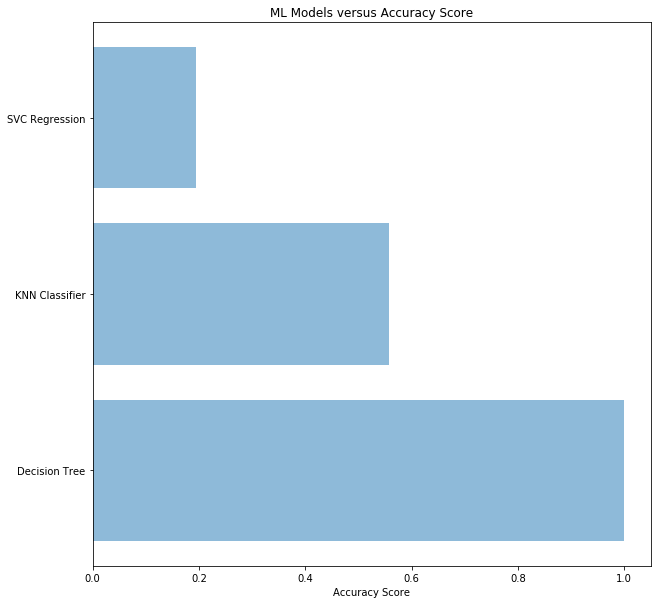

In [61]:
# visualize accuracy scores

features = all_accuracy_models
corr_nums = all_accuracy_scores

plt.figure(figsize=(10,10))
plt.barh(features, corr_nums, align='center', alpha=0.5)
plt.yticks(features, features)
plt.xlabel('Accuracy Score')
plt.title('ML Models versus Accuracy Score')

plt.show()